# Midterm Project

## Required Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import gc


In [2]:
data = pd.read_excel('AmesHousing.xls')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


We will not use `Order` and `PID` variables.

In [3]:
data = data.drop(['Order', 'PID'], axis=1)

## Columns by type of data

In [4]:
ordinal_columns = [
    'Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond',
    'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
    'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical',
    'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish',
    'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence'
]

nominal_columns = [
    'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour',
    'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
    'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
    'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type',
    'Misc Feature', 'Sale Type', 'Sale Condition'
]

discrete_columns = [
    'Year Built',
    'Year Remod/Add',
    'Bsmt Full Bath',
    'Bsmt Half Bath',
    'Full Bath',
    'Half Bath',
    'Bedroom AbvGr',
    'Kitchen AbvGr',
    'TotRms AbvGrd',
    'Fireplaces',
    'Garage Yr Blt',
    'Garage Cars',
    'Mo Sold',
    'Yr Sold',
]

continuous_columns = [
    'Lot Frontage',
    'Lot Area',
    'Mas Vnr Area',
    'Mas Vnr Area',
    'BsmtFin SF 1',
    'BsmtFin SF 2',
    'Bsmt Unf SF',
    'Total Bsmt SF',
    '1st Flr SF',
    '2nd Flr SF',
    'Low Qual Fin SF',
    'Gr Liv Area',
    'Garage Area',
    'Wood Deck SF',
    'Open Porch SF',
    'Enclosed Porch',
    '3Ssn Porch',
    'Screen Porch',
    'Pool Area',
    'Misc Val',
]

## Preprocessing: Dealing with `NaN`

Since for ordinal and nominal columns `NaN` means a value of type `N/A` and not a missing value, we replace the missing value label with `N/A`.

In [5]:
# NaN => N/A
data[ordinal_columns] = data[ordinal_columns].fillna("N/A")
data[nominal_columns] = data[nominal_columns].fillna("N/A")

To get rid of `NaN` values in continuous values, we can either drop them or fill them with a random variable sampled from a random normal distribution with the same mean and variance. Dropping them will affect approximately 16.7% of the lot frontage column. Assuming normal distribution could be potentially strong. Instead, let us fill them with the most frequently seen data using `scikit-learn.Imputer`.

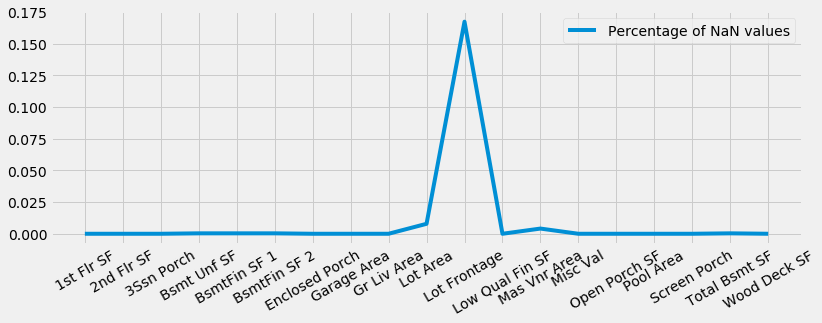

In [6]:
plt.figure(figsize=(12, 4))
ax = sns.lineplot(
    x=continuous_columns,
    y=(data[continuous_columns].isna().sum() /
       data[continuous_columns].shape[0]).sort_values(ascending=False),
    label="Percentage of NaN values")
_ = plt.xticks(rotation=30)

# Question 1

_Visualize the univariate distribution of each continuous input variable, and the distribution of the target variable. Write down anything you find worth noting. Is there something that might require special treatment?_

Let us check each distribution and decide for which values we will use mean, median, or most frequent

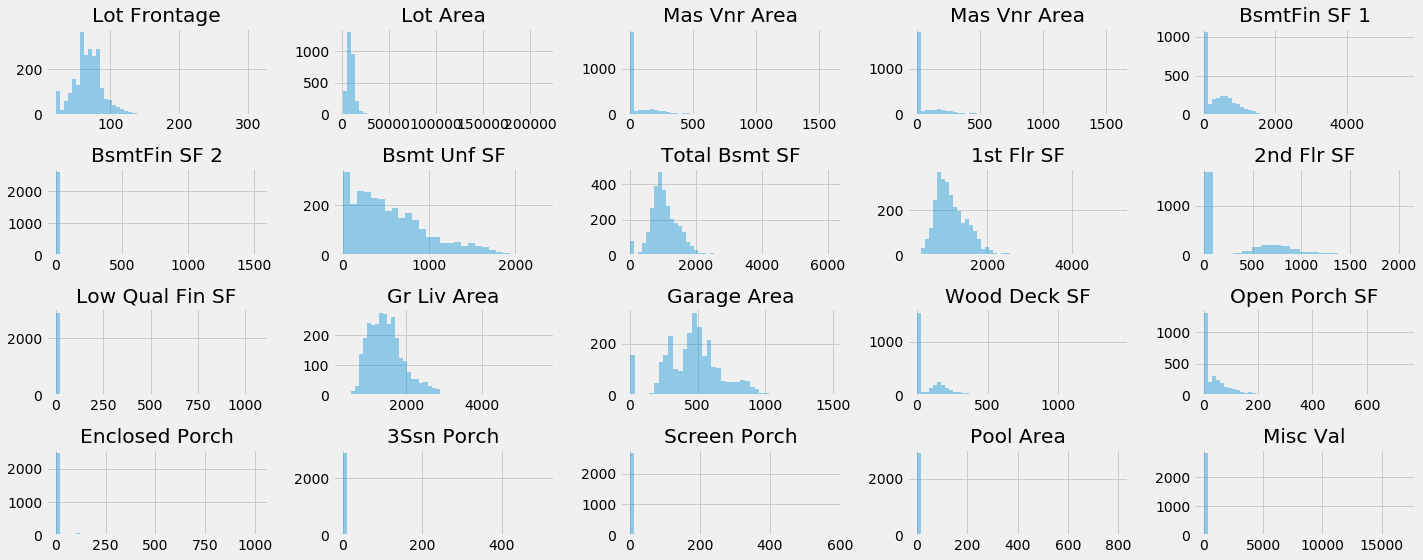

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20, 8))
k = 0
for i in range(4):
    for j in range(5):
        sns.distplot(data[continuous_columns[k]].values,
                     ax=ax[i, j],
                     kde=False)
        ax[i, j].set_title(continuous_columns[k])
        k += 1
plt.tight_layout()

Quite a few variables are mostly zeros! In addition, many variables are significantly biased towards being zero. 

To get rid of `NaN`s, we will use `mean` replacement strategy for `Lot Frontage`, `Bsmt Unf SF`, `Total Bsmt SF`, `1st Flr SF`, `Gr Liv Area`, `Garage Area`, the rest we will replace with most frequent

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data[[
    'Lot Frontage', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
    'Gr Liv Area', 'Garage Area'
]] = imputer.fit_transform(data[[
    'Lot Frontage', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
    'Gr Liv Area', 'Garage Area'
]])
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
c = [
    x for x in continuous_columns if not x in [
        'Lot Frontage', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
        'Gr Liv Area', 'Garage Area'
    ]
]
data[c] = imputer.fit_transform(data[c])

Nothing is said about other discrete values being `NaN`, let us deal with those. There are four columns affected:

In [9]:
data[discrete_columns].isna().sum().sort_values(ascending=False)

Garage Yr Blt     159
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Cars         1
Yr Sold             0
Mo Sold             0
Fireplaces          0
TotRms AbvGrd       0
Kitchen AbvGr       0
Bedroom AbvGr       0
Half Bath           0
Full Bath           0
Year Remod/Add      0
Year Built          0
dtype: int64

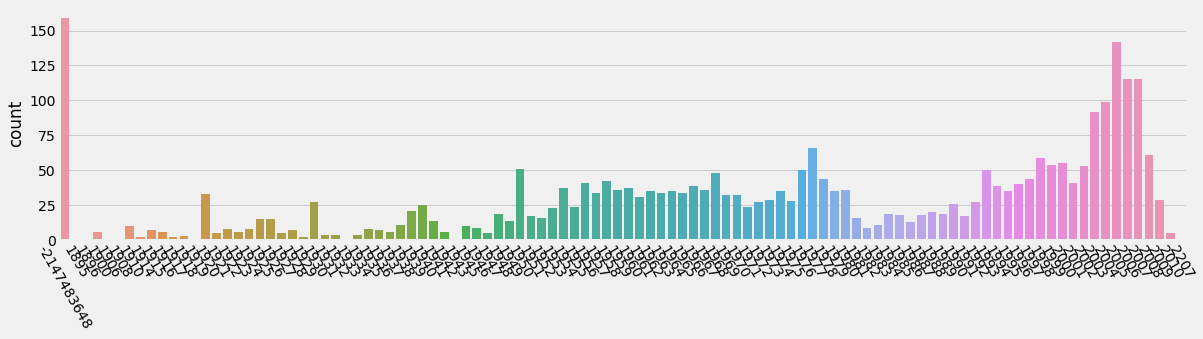

In [10]:
plt.figure(figsize=(18, 4))
_ = sns.countplot(data['Garage Yr Blt'].values.astype(np.int32))
_ = plt.xticks(rotation=-60)

Note the number of NaNs (the leftmost column) and the year 2207 on the very right.

In [11]:
data = data[data['Garage Yr Blt']<2207]
data = data[data['Garage Yr Blt'].notna()]

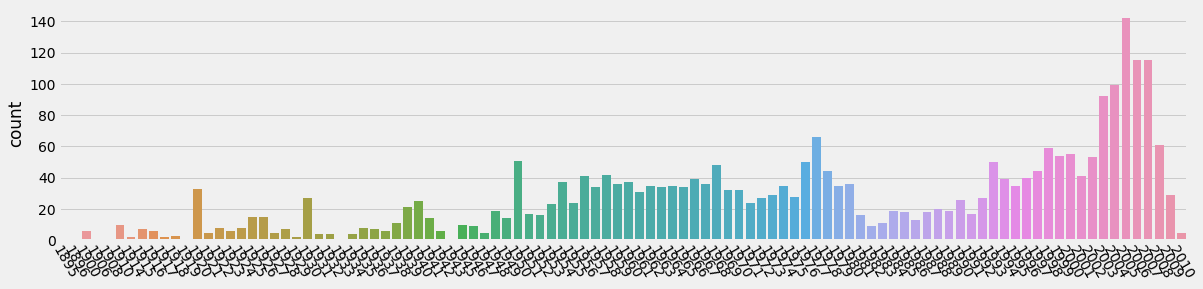

In [12]:
plt.figure(figsize=(18, 4))
_ = sns.countplot(data['Garage Yr Blt'].values.astype(np.int32))
_ = plt.xticks(rotation=-60)

The next columns are `Bsmt Half Bath` and `Bsmt Full Bath`

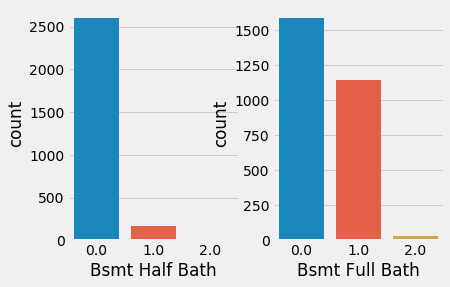

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2)
_ = sns.countplot(data['Bsmt Half Bath'], ax=ax[0])
_ = sns.countplot(data['Bsmt Full Bath'], ax=ax[1])

Since we only need to replace 2 values out of over 2500, we replace `NaN`s with most frequently seen 0's.

In [14]:
data['Bsmt Half Bath'] = data['Bsmt Half Bath'].fillna(0)
data['Bsmt Full Bath'] = data['Bsmt Full Bath'].fillna(0)


And so we have no missing values:

In [15]:
data.isna().values.any()

False

# Question 3

_Visualize the dependency of the target on each continuous feature via scatter plot._

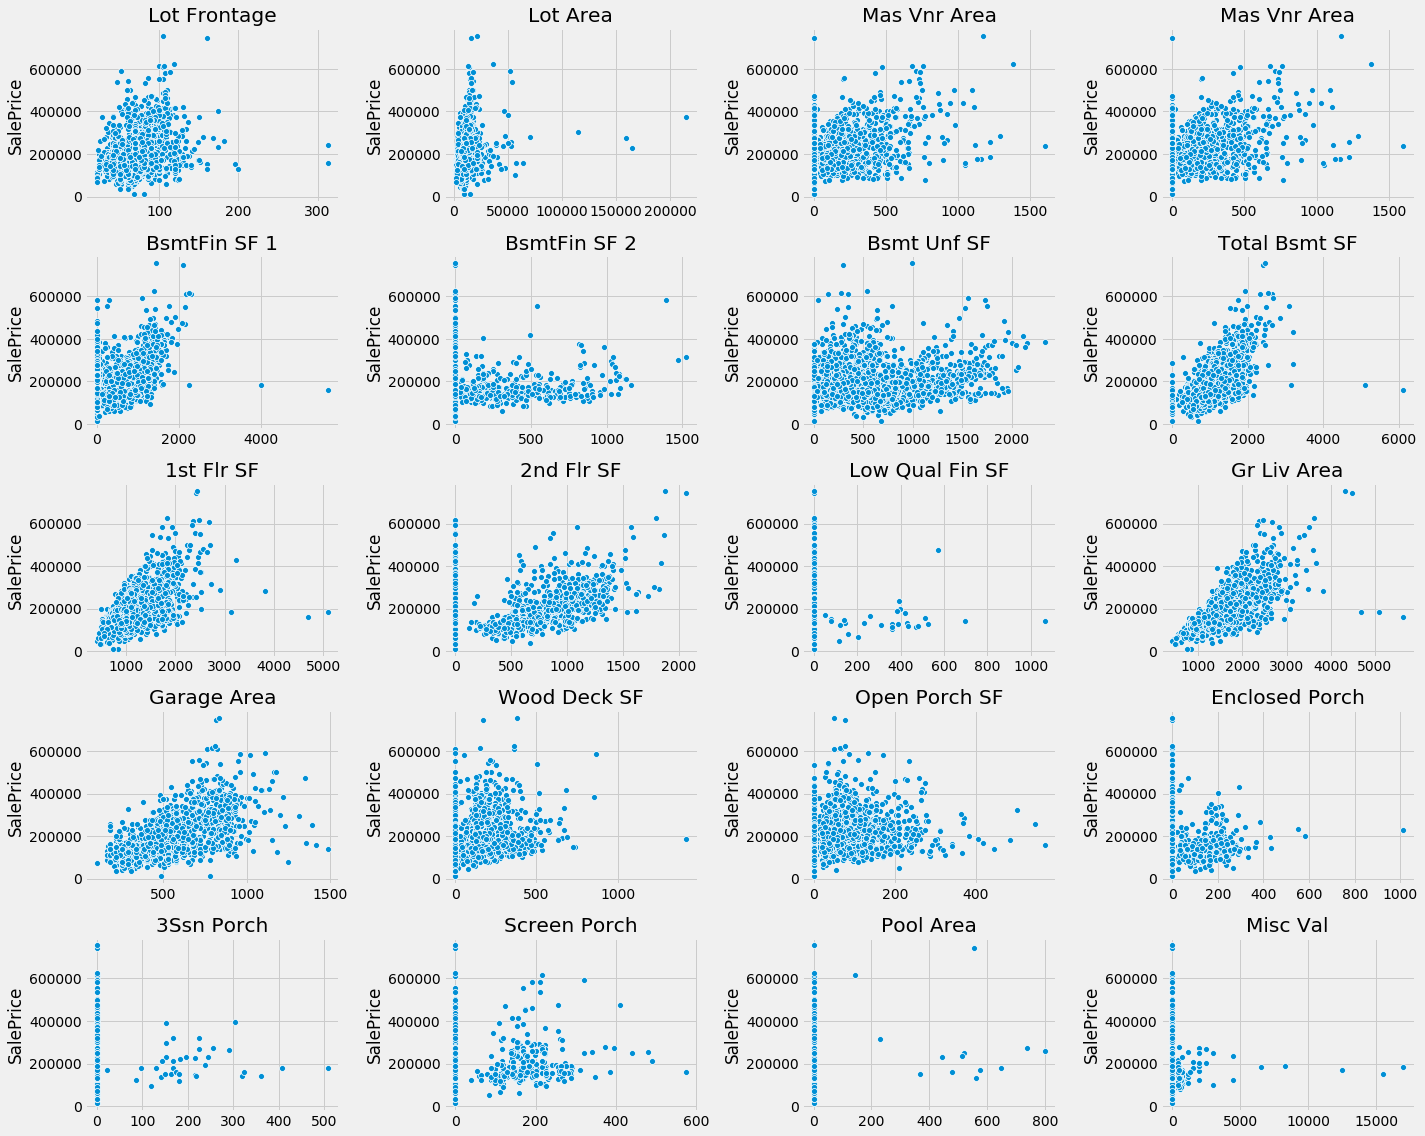

In [16]:
target = data['SalePrice']
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 16))
k = 0
for i in range(5):
    for j in range(4):
        sns.scatterplot(data[continuous_columns[k]].values,
                        target,
                        ax=ax[i, j])
        ax[i, j].set_title(continuous_columns[k])
        k += 1
plt.tight_layout()

From the grid of scatter plots we can see that some variables have a better dependence than others. Consider Enclosed Porch and Garage area vs Pool Area and BsmtFin SF 2. The former two look more dependent, while pool area does not show any new information to us. Same for BsmtFin SF 2: the price does not seem to depend on that value.

The categorical variables that we are going to consider throughout are going to be Ordinal Variables and Nominal, some of which are represented by `string` values

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm.notebook import tqdm

# Question 3

_Split data in training and test set. Do not use the test-set unless for a final evaluation in Step 6. For each categorical variable, cross-validate a Linear Regression model using just this variable (one-hot-encoded). Visualize the relationship of the categorical variables that provide the best R^2 value with the target._

We combine names of all categorical variables into one list:

In [18]:
categorical_variables = nominal_columns+ordinal_columns

Let us split the data into training and testing sets using only categorical variables

In [19]:
data_train, data_test, target_train, target_test = train_test_split(
    data.drop(['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.2,
    random_state=42,
)

kfold = KFold(n_splits=5)
score_per_col = defaultdict()

Now we can proceed to creating a pipeline with transformation of columns.

## Cross Validation: Linear Regression

Through trial and error, it seems that due to some variables being present in the data set only once (that is a year 1914 is seen just once for instance), I decided to structure the training loop as follows:
for every categorical variable I `fit_transform` the column preprocessor on the whole dataset, then split into folds. We are not worried about any leakage into test set here since we do not carry any statistical distribution in our transform, but in general one must be careful about leakage.

In [20]:
for each_cat in categorical_variables:
    scores = []
    preprocessor = ColumnTransformer([
        ('one-hot-encode', OneHotEncoder(sparse=False), [each_cat])
    ])
    preprocessor = preprocessor.fit(data_train)
    for train_id, valid_id in kfold.split(data_train):
        x_train, y_train = data_train.iloc[
            train_id, :], target_train.iloc[train_id]
        x_val, y_val = data_train.iloc[
            valid_id, :], target_train.iloc[valid_id]

        x_train = preprocessor.transform(x_train)
        x_val = preprocessor.transform(x_val)

        model = LinearRegression()

        model = model.fit(x_train, y_train)

        y_pred = model.predict(x_val)

        scores.append(r2_score(y_true=y_val, y_pred=y_pred))
    score_per_col[each_cat] = scores

Next we sort the scores to extract top 5 best and worst scores per feature and plot how the target depends on the value of each feature.

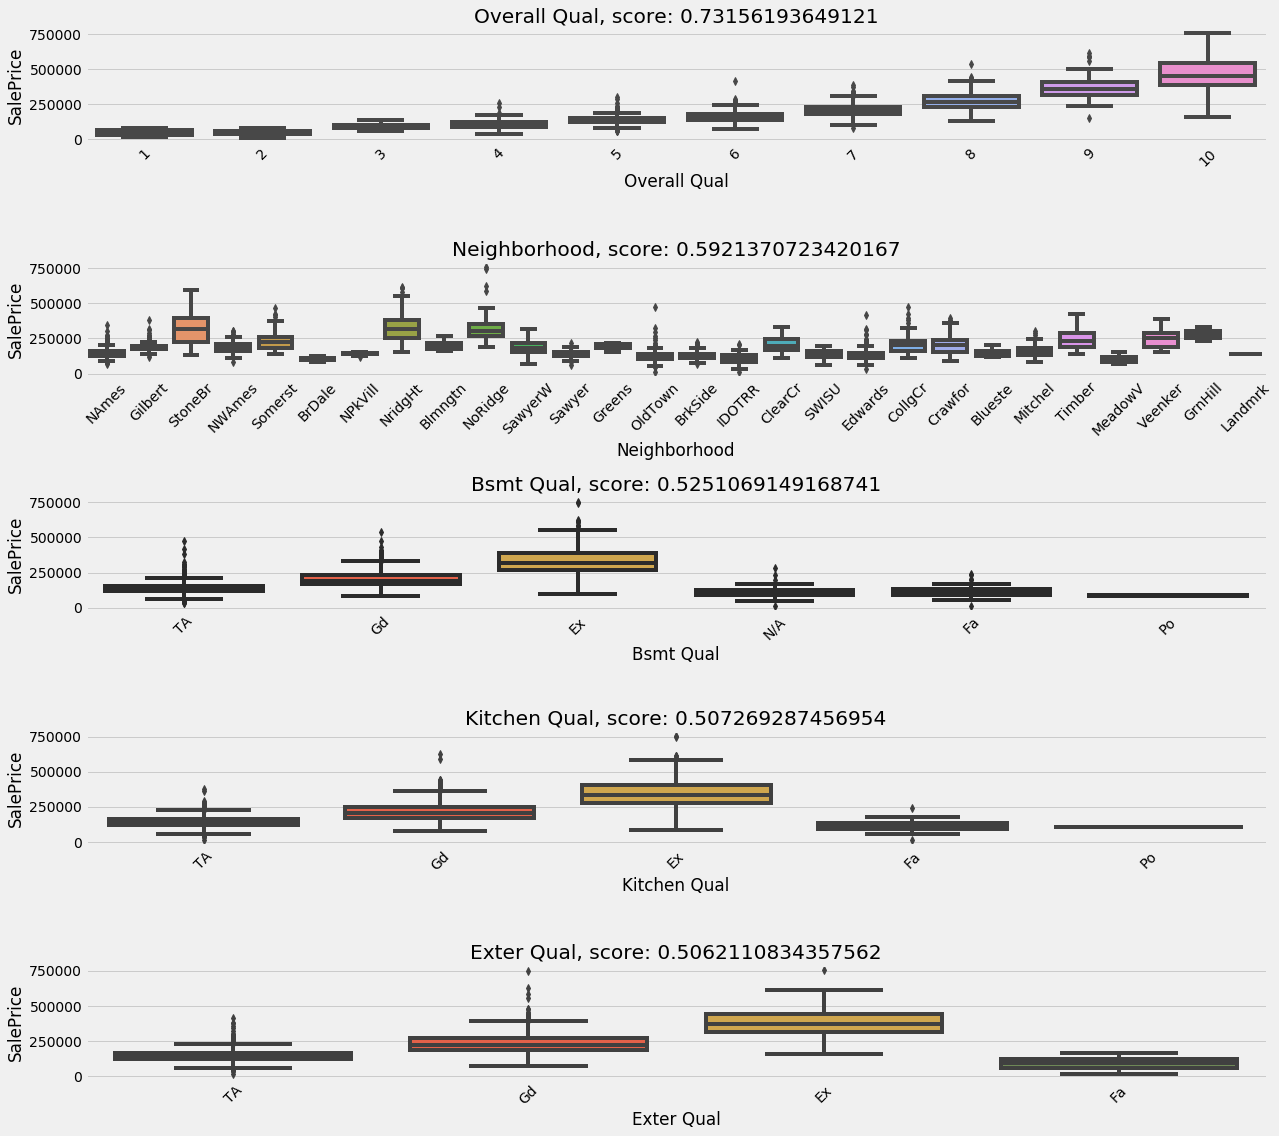

In [21]:
scores_sorted = {
    k: max(v)
    for k, v in sorted(
        score_per_col.items(), key=lambda item: max(item[1]), reverse=True)
}

top5_feats = list(scores_sorted.keys())[:5]
worst5_feats = list(scores_sorted.keys())[-5:]

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(18, 16))
for i in range(5):
    chart = sns.boxplot(data[top5_feats].iloc[:, i], target, ax=ax[i])
    ax[i].set_title(f"{top5_feats[i]}, score: {scores_sorted[top5_feats[i]]}") 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
#plt.xticks(rotation=45)
plt.tight_layout()

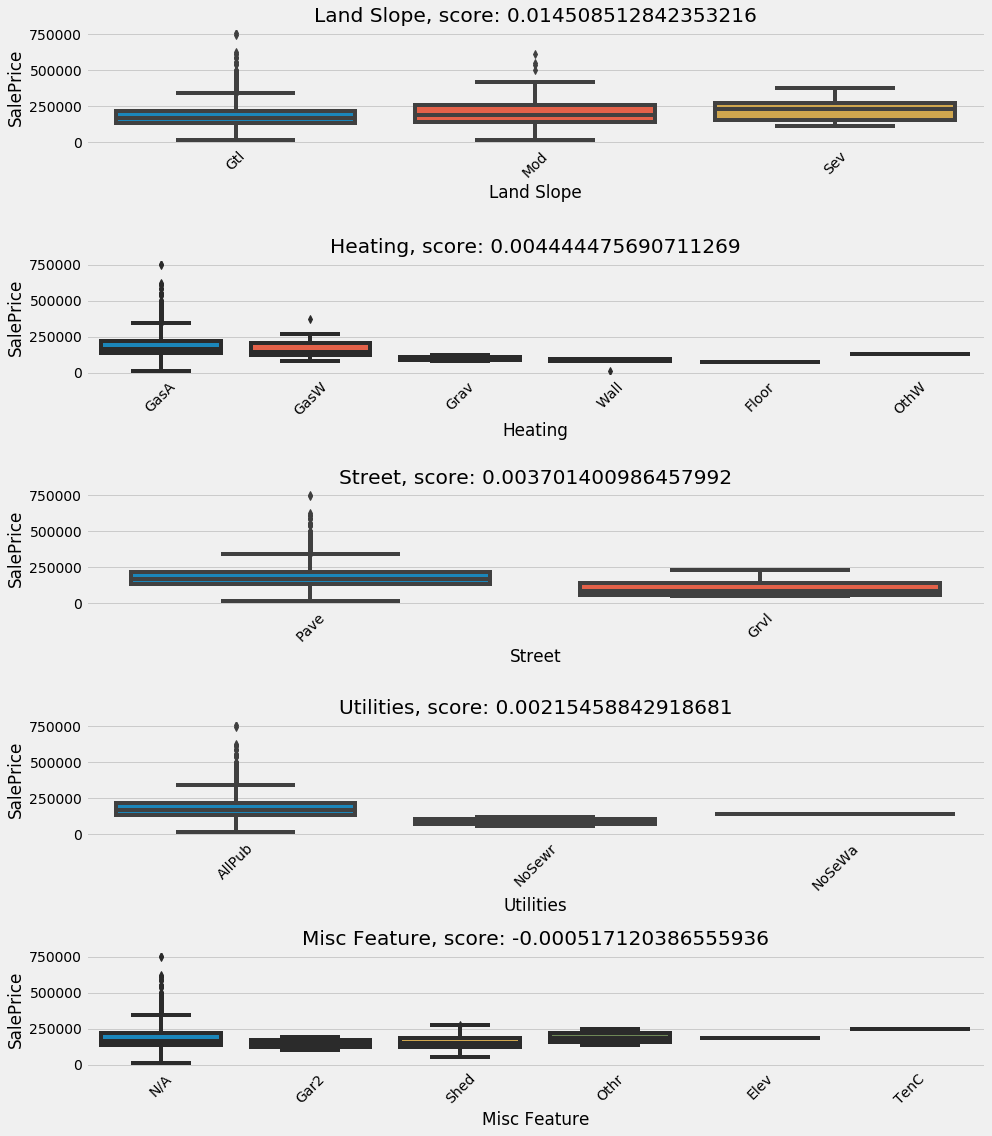

In [22]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(14,16))
for i in range(5):
    chart = sns.boxplot(data[worst5_feats].iloc[:,i], target, ax = ax[i])
    ax[i].set_title(f"{worst5_feats[i]}, score: {scores_sorted[worst5_feats[i]]}")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.tight_layout()

# Question 4

_Use ColumnTransformer and pipeline to encode categorical variables. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. Does scaling the data (within the pipeline) with StandardScaler help?_

## Cross Validation with Pipeline

We will apply one-hot encoding to the variables that are presented in the list of categorical variables, while other numerical (continuous) values will remain the same and may only standard-scaled (we achieve that by passing the `remainder` argument to the `ColumnTransformer`).

### Linear Regression

The overall pipeline of algorithm is as follows. First the data is preprocessed by a column transformer with or without standard scaler. Then this preprocessor is applied to the training data which is then passed onto the classifier for 5-fold cross-validation.

#### Without Scaler

In [23]:
preprocessor = ColumnTransformer(
    [('one-hot-encode', OneHotEncoder(sparse=False,  handle_unknown='ignore'),
      categorical_variables)],
    remainder='passthrough')

data_train_transformed = preprocessor.fit_transform(data_train)
scores = []

for train_id, valid_id in kfold.split(data_train_transformed):
    model = LinearRegression()

    x_train, y_train = data_train_transformed[
        train_id, :], target_train.iloc[train_id]
    x_val, y_val = data_train_transformed[
        valid_id, :], target_train.iloc[valid_id]

    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    scores.append(r2_score(y_true=y_val, y_pred=y_pred))

print(f'Mean R^2 score: {np.mean(scores)}, Std: {np.std(scores)}')

Mean R^2 score: -3328316792179739.0, Std: 6654937763767652.0


Notice that Linear Regression does not offer good performance without regularization when all features are combined together

#### With Scaler

In [24]:
numerical_columns = list(set(data_train.columns).difference(categorical_variables))

In [25]:
preprocessor = ColumnTransformer([
    ('one-hot-encode', OneHotEncoder(sparse=False,  handle_unknown='ignore'),
     categorical_variables),
    ('standard-scaler', StandardScaler(),
     numerical_columns)
])

data_train_transformed = preprocessor.fit_transform(data_train)
scores = []
for train_id, valid_id in kfold.split(data_train_transformed):
    model = LinearRegression()

    x_train, y_train = data_train_transformed[
        train_id, :], target_train.iloc[train_id]
    x_val, y_val = data_train_transformed[
        valid_id, :], target_train.iloc[valid_id]

    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    scores.append(r2_score(y_true=y_val, y_pred=y_pred))

print(f'Mean R^2 score: {np.mean(scores)}, Std: {np.std(scores)}')

Mean R^2 score: -9.640723682715259e+18, Std: 9.781869103801948e+18


Standard scaling does not offer any advantages here.

### Ridge Regression

#### Without Scaler

In [26]:
preprocessor = ColumnTransformer(
    [('one-hot-encode', OneHotEncoder(sparse=False, handle_unknown='ignore'),
      categorical_variables)],
    remainder='passthrough')
data_train_transformed = preprocessor.fit_transform(data_train)

scores = []
for train_id, valid_id in kfold.split(data_train_transformed):
    model = Ridge()

    x_train, y_train = data_train_transformed[
        train_id, :], target_train.iloc[train_id]
    x_val, y_val = data_train_transformed[
        valid_id, :], target_train.iloc[valid_id]

    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    scores.append(r2_score(y_true=y_val, y_pred=y_pred))
    
print(f'Mean R^2 score: {np.mean(scores):.2f}, Std: {np.std(scores):.2f}')

Mean R^2 score: 0.85, Std: 0.07


Ridge regularization performs much better, even without the scaling.

#### With Scaler

In [27]:
preprocessor = ColumnTransformer([
    ('one-hot-encode', OneHotEncoder(sparse=False,  handle_unknown='ignore'),
     categorical_variables),
    ('standard-scaler', StandardScaler(),
     numerical_columns)
])

data_train_transformed = preprocessor.fit_transform(data_train)
scores = []
for train_id, valid_id in kfold.split(data_train_transformed):
    model = Ridge()

    x_train, y_train = data_train_transformed[
        train_id, :], target_train.iloc[train_id]
    x_val, y_val = data_train_transformed[
        valid_id, :], target_train.iloc[valid_id]

    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    scores.append(r2_score(y_true=y_val, y_pred=y_pred))
    
print(f'Mean R^2 score: {np.mean(scores):.2f}, Std: {np.std(scores):.2f}')

Mean R^2 score: 0.85, Std: 0.07


Notice that scaling does not offer any advantages in the ridge model.

### Lasso Regression

#### Without Scaler

For the purpose of concise result presentation, I will suppress the warnings about non-convergence but we will note that the model does not converge with default parameters.

I tried increasing number of iterations to ~100000 and it still returns warnings while performance was unaffected.

In [28]:
%%capture
preprocessor = ColumnTransformer(
    [('one-hot-encode', OneHotEncoder(sparse=False,  handle_unknown='ignore'),
      categorical_variables)],
    remainder='passthrough')
data_train_transformed = preprocessor.fit_transform(data_train)

scores = []
for train_id, valid_id in kfold.split(data_train_transformed):
    model = Lasso()

    x_train, y_train = data_train_transformed[
        train_id, :], target_train.iloc[train_id]
    x_val, y_val = data_train_transformed[
        valid_id, :], target_train.iloc[valid_id]

    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    scores.append(r2_score(y_true=y_val, y_pred=y_pred))

In [29]:
print(f'Mean R^2 score: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}')

Mean R^2 score: 0.8290, Std: 0.1234


#### With Scaler

In [30]:
%%capture
preprocessor = ColumnTransformer([
    ('one-hot-encode', OneHotEncoder(sparse=False, handle_unknown='ignore'),
     categorical_variables),
    ('standard-scaler', StandardScaler(),
     numerical_columns)
])

data_train_transformed = preprocessor.fit_transform(data_train)
scores = []
for train_id, valid_id in kfold.split(data_train_transformed):
    model = Lasso()

    x_train, y_train = data_train_transformed[
        train_id, :], target_train.iloc[train_id]
    x_val, y_val = data_train_transformed[
        valid_id, :], target_train.iloc[valid_id]

    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    scores.append(r2_score(y_true=y_val, y_pred=y_pred))

In [31]:
print(f'Mean R^2 score: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}')

Mean R^2 score: 0.8292, Std: 0.1232


While Lasso regression performs better than Ridge, standard scaling offers only a small improvement

### Elastic Net

#### Without Scaler

In [32]:
%%capture
preprocessor = ColumnTransformer(
    [('one-hot-encode', OneHotEncoder(sparse=False, handle_unknown='ignore'),
      make_column_selector(dtype_include=object))],
    remainder='passthrough')
data_train_transformed = preprocessor.fit_transform(data_train)

scores = []
for train_id, valid_id in kfold.split(data_train_transformed):
    model = ElasticNet()

    x_train, y_train = data_train_transformed[
        train_id, :], target_train.iloc[train_id]
    x_val, y_val = data_train_transformed[
        valid_id, :], target_train.iloc[valid_id]

    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    scores.append(r2_score(y_true=y_val, y_pred=y_pred))

In [33]:
print(f'Mean R^2 score: {np.mean(scores):.2f}, Std: {np.std(scores):.2f}')

Mean R^2 score: 0.83, Std: 0.06


#### With Scaler

In [34]:
%%capture
preprocessor = ColumnTransformer([
    ('one-hot-encode', OneHotEncoder(sparse=False, handle_unknown='ignore'),
     categorical_variables),
    ('standard-scaler', StandardScaler(),
     make_column_selector(dtype_include=np.number))
])

data_train_transformed = preprocessor.fit_transform(data_train)
scores = []
for train_id, valid_id in kfold.split(data_train_transformed):
    model = ElasticNet()

    x_train, y_train = data_train_transformed[
        train_id, :], target_train.iloc[train_id]
    x_val, y_val = data_train_transformed[
        valid_id, :], target_train.iloc[valid_id]

    model = model.fit(x_train, y_train)

    y_pred = model.predict(x_val)
    scores.append(r2_score(y_true=y_val, y_pred=y_pred))

In [35]:
print(f'Mean R^2 score: {np.mean(scores):.2f}, Std: {np.std(scores):.2f}')

Mean R^2 score: 0.84, Std: 0.04


So far, Elastic Net with standard scaling is seems to be the best with the smallest variance between folds.

# Question 5

_Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet._

## Grid Search Cross Validation

Standard Scaling did provide improvements for the models above, so we will use it in the grid search.

### Ridge

We are forced to fit the preprocessor on the whole dataset in order to properly apply the model to the testing data since some classes are present in the test set but not training set.

Normally, this would lead to data leaks: we use information from test set on train data, but since we do not deal with scaling the data and this is a simple example, our One-Hot encoding can be assume to be leak-free.

Another way of dealing with this issue could be simply dropping problematic data instances from the test set.

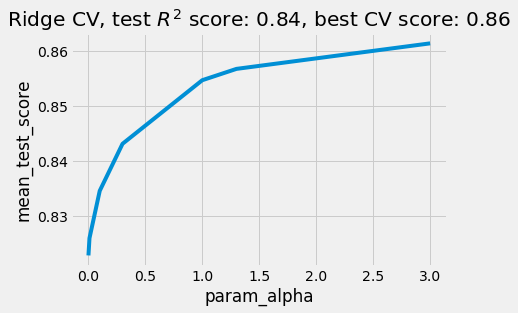

In [36]:
preprocessor = ColumnTransformer([
    ('one-hot-encode', OneHotEncoder(sparse=False, handle_unknown='ignore'),
     categorical_variables),
    ('standard-scaler', StandardScaler(),
     numerical_columns)
])

data_train_transformed = preprocessor.fit_transform(data_train)

params = {'alpha': (0.001, 0.01, 0.1, 0.3, 1.0, 1.3, 3.0)}

ridge_cv = GridSearchCV(estimator=Ridge(random_state=42),
                        param_grid=params,
                        cv=5,
                        scoring=make_scorer(r2_score),
                        verbose=0)
ridge_cv.fit(data_train_transformed, target_train)
cv_results = pd.DataFrame(ridge_cv.cv_results_)

model = ridge_cv.best_estimator_
y_pred = model.predict(preprocessor.transform(data_test))
score = r2_score(y_pred, target_test)
sns.lineplot(data=cv_results, x='param_alpha', y='mean_test_score')
_ = plt.title(
    f"Ridge CV, test $R^2$ score: {score:.2f}, best CV score: {ridge_cv.best_score_:.2f}"
)

### Lasso

The model fails to converge even with 100,000 iterations, so I won't increase them by much

In [37]:
%%capture
preprocessor = ColumnTransformer([
    ('one-hot-encode', OneHotEncoder(sparse=False, handle_unknown='ignore'),
     categorical_variables),
    ('standard-scaler', StandardScaler(),
     numerical_columns)
])

data_train_transformed = preprocessor.fit_transform(data_train)

params = {'alpha': (0.001, 0.01, 0.1, 0.3, 1.0, 1.3, 3.0)}

lasso_cv = GridSearchCV(estimator=Lasso(max_iter=1_000, random_state=42),
                        param_grid=params,
                        cv=5,
                        scoring=make_scorer(r2_score),
                        verbose=0)
lasso_cv.fit(data_train_transformed, target_train)



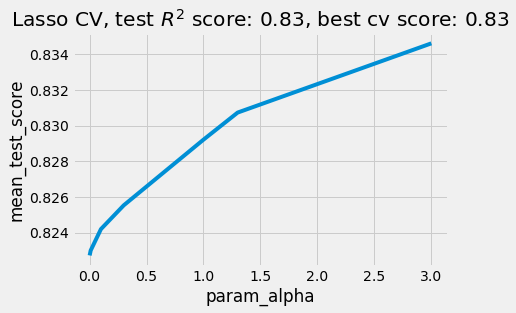

In [38]:
cv_results = pd.DataFrame(lasso_cv.cv_results_)

model = lasso_cv.best_estimator_
y_pred = model.predict(preprocessor.transform(data_test))
score = r2_score(y_pred, target_test)
sns.lineplot(data=cv_results, x='param_alpha', y='mean_test_score')
_ = plt.title(
    f"Lasso CV, test $R^2$ score: {score:.2f}, best cv score: {lasso_cv.best_score_:.2f}"
)

### ElasticNet

In [39]:
%%capture
preprocessor = ColumnTransformer([
    ('one-hot-encode', OneHotEncoder(sparse=False, handle_unknown='ignore'),
     categorical_variables),
    ('standard-scaler', StandardScaler(),
     numerical_columns)
])

data_train_transformed = preprocessor.fit_transform(data_train)

params = {
    'alpha': (0.001, 0.01, 0.1, 0.3, 1.0, 1.3, 3.0),
    'l1_ratio': (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
}

enet_cv = GridSearchCV(estimator=ElasticNet(max_iter=1_000, random_state=42),
                       param_grid=params,
                       cv=5,
                       scoring=make_scorer(r2_score),
                       verbose=0)
enet_cv.fit(data_train_transformed, target_train)
cv_results = pd.DataFrame(enet_cv.cv_results_)

model = enet_cv.best_estimator_
y_pred = model.predict(preprocessor.transform(data_test))
score = r2_score(y_pred, target_test)

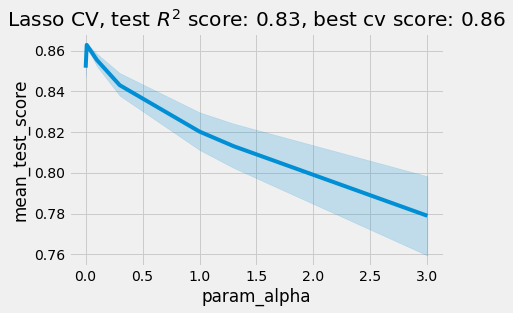

In [40]:
score = r2_score(y_pred, target_test)
sns.lineplot(data=cv_results, x='param_alpha', y='mean_test_score')
_ = plt.title(
    f"Lasso CV, test $R^2$ score: {score:.2f}, best cv score: {enet_cv.best_score_:.2f}"
)

# Question 5

_Visualize the coefficients of the resulting models. Do they agree on which features are important? Evaluate the model performance on the test set._

## Analysis of each classifier

In [41]:
best_ridge = ridge_cv.best_estimator_
best_lasso = lasso_cv.best_estimator_
best_elastic = enet_cv.best_estimator_

In order to interpret each classifier's feature preference, we will perform the following coefficient transform. Notice that after one-hot encoding each feature in the column turned into the $k$-length vector, where $k$ is the number of unique elements in the column. By nature of the `ColumnTrasformer`, after performing the One-Hot encoding, the columns are concatenated, so that if column $i$ has $k_i$ categories and column $i+1$ has $k_{i+1}$ categories, the resulting matrix will have $k_i+k_{i+1}$ columns.

Let us extract the number of unique sizes by extracting that information as length of the vector of categories from One-Hot-Encoder

In [42]:
onehot_encoder = preprocessor.transformers_[0][1]
unique_sizes = [len(x) for x in onehot_encoder.categories_]
print(sum(unique_sizes))

305


In [43]:
ss = preprocessor.named_transformers_['standard-scaler']

In [44]:
best_ridge.coef_.shape

(338,)

There are 305 0-1 values in the dataset which means there are 305 coefficients for one-hot encoding. Consider a column $i$ and assume it has $k_i$ unique values. This means that we need to extract $k_i$ coefficients from the model and they will effectively represent the $i$th feature (column).

### Get Coefficients

To deal with how many coefficients represent one-hot encoded variables we will simply find the mean per category and use that.

In [45]:
coefficients_ridge = best_ridge.coef_

offset = 0
oh_coeffs_ridge = defaultdict()
for idx, s in enumerate(unique_sizes):
    oh_coeffs_ridge[categorical_variables[idx]] = np.mean(coefficients_ridge[offset:offset+s])
    offset+=s
for each in numerical_columns:
    oh_coeffs_ridge[each] = coefficients_ridge[offset:offset+1][0]
    offset+=1

coefficients_lasso = best_lasso.coef_
offset = 0
oh_coeffs_lasso = defaultdict()
for idx, s in enumerate(unique_sizes):
    oh_coeffs_lasso[categorical_variables[idx]] = np.mean(coefficients_lasso[offset:offset+s])
    offset+=s
for each in numerical_columns:
    oh_coeffs_lasso[each] = coefficients_lasso[offset:offset+1][0]
    offset+=1
    
coefficients_elastic = best_elastic.coef_
offset = 0
oh_coeffs_elastic = defaultdict()
for idx, s in enumerate(unique_sizes):
    oh_coeffs_elastic[categorical_variables[idx]] = np.mean(coefficients_elastic[offset:offset+s])
    offset+=s
for each in numerical_columns:
    oh_coeffs_elastic[each] = coefficients_elastic[offset:offset+1][0]
    offset+=1

In [46]:
oh_coeffs_ridge = pd.DataFrame.from_dict(oh_coeffs_ridge, orient='index').T
oh_coeffs_elastic = pd.DataFrame.from_dict(oh_coeffs_elastic, orient='index').T
oh_coeffs_lasso = pd.DataFrame.from_dict(oh_coeffs_lasso, orient='index').T

Let us check the agreement between the coefficient values for categorical and numerical variables separately starting with numerical. We will plot a bar chart for each coefficient and place them side-by-side for each model

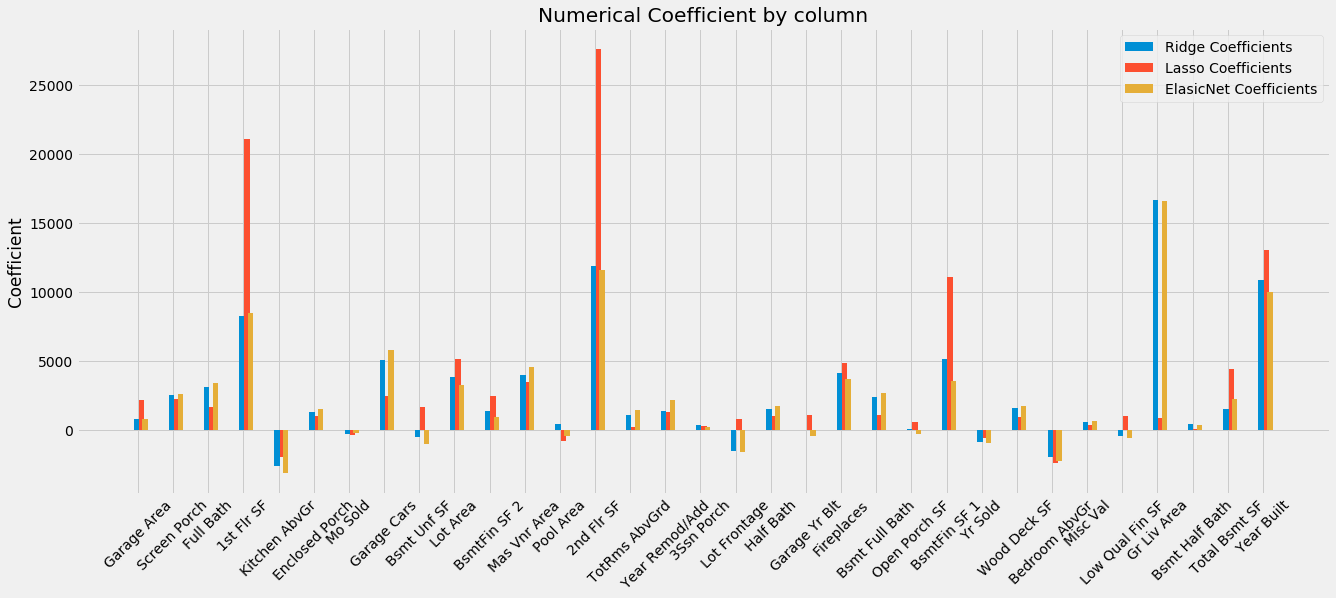

In [47]:
x = np.arange(len(numerical_columns))
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 8))
rects1 = ax.bar(x - width/3,  oh_coeffs_ridge.values.ravel()[len(categorical_variables):], 
                width, label='Ridge Coefficients')
rects2 = ax.bar(x + 2*width/3,  oh_coeffs_lasso.values.ravel()[len(categorical_variables):], 
                width, label='Lasso Coefficients')
rects3 = ax.bar(x + 4*width/3,  oh_coeffs_elastic.values.ravel()[len(categorical_variables):], 
                width, label='ElasicNet Coefficients')
ax.set_ylabel('Coefficient')
ax.set_title('Numerical Coefficient by column')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(numerical_columns)
_=ax.legend()

There are significant value differences between coefficients for categorical variables, which cannot be neglected. This indicates less agreement than we observed for numerical values. In order to properly visualize this, let replace each coefficient $C_i$ with $\frac{C_i}{\sum\limits_k C_k}$ which basically shows how much each coefficient stands out from the rest. This can mitigate the absolute difference in coefficients and allow us to better visualize them together. In addition, coefficients that have similar values will be more evident.

In [48]:
coefs1 = oh_coeffs_lasso[categorical_variables].values.ravel()
coefs1 /= (coefs1.sum())
coefs2 = oh_coeffs_ridge[categorical_variables].values.ravel()
coefs2 /= (coefs2.sum())
coefs3 = oh_coeffs_elastic[categorical_variables].values.ravel()
coefs3 /= (coefs3.sum())

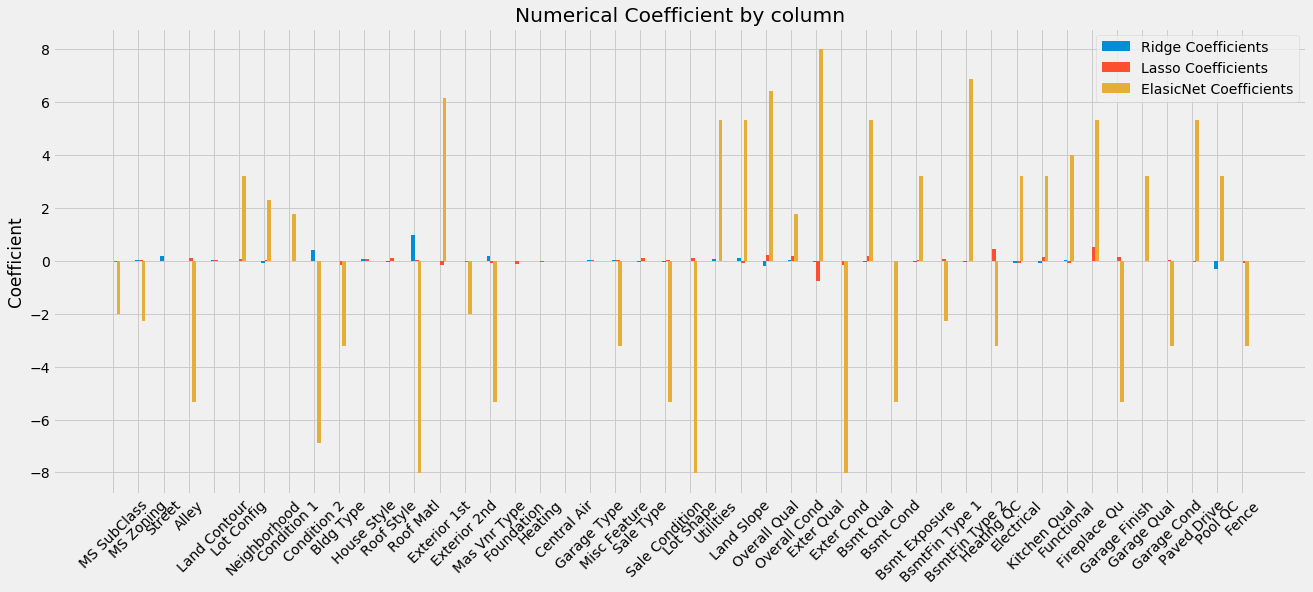

In [49]:

x = np.arange(len(categorical_variables))
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 8))
rects1 = ax.bar(x - width/3,  coefs1,
                width, label='Ridge Coefficients')
rects2 = ax.bar(x + 2*width/3,  coefs2,
                width, label='Lasso Coefficients')
rects3 = ax.bar(x + 4*width/3,  coefs3,
                width, label='ElasicNet Coefficients')
ax.set_ylabel('Coefficient')
ax.set_title('Numerical Coefficient by column')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categorical_variables)
_ = ax.legend()

We observe less agreement on categorical variables than on numerical ones.

# Conclusion

In this project we approached a large data analysis problem for regression. We started by analyzing distributions of continuous variables and noting how standard scaling might be useful in the process of predicting the price.

By looking at scatter plots of the target vs. continuous variables we were able to identify some of the relationships that are present in the data set.

We identified categorical variables which get the best and worst $R^2$ score when used individually for a linear regression model without regularization. If the categorical variables are used together without regularization the results are considerably worse with respect to the $R^2$ score.

Using column transformer, scaling and one-hot encoding we were able to train linear regression models with various types of regression on the dataset. The best results during cross validation were observed for Lasso regression with $\alpha\approx 3$ and $R^2_{CV}=0.86$. However, the best test set performance was seen in Ridge Regression, $\alpha\approx 3$ and $R^2_{Test}=0.84$.

We observed how models mostly agree in coefficients of numerical variables but disagree about importances of categorical variables. I conclude that this is due to amount of noise those variables introduce when combined together: a lot of them are highly imbalanced and thus should be dealt with carefully.